In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as sp
#%matplotlib qt5

In [2]:
file = open("data.bin", "r")
interleaved_data = np.fromfile(file, np.uint8)
file.close()
# the data is sampled at 2.4Mhz
fs = 2.4E6 #Sampling frequency of SDR
dt = 1/(fs) #Timestep between samples 

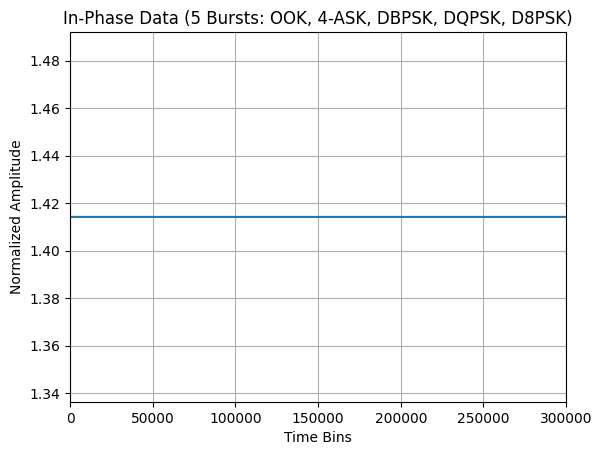

In [3]:
# I used this trick to de-interleave the data. There are many other methods.
# The data is in the form " real imag real imag real imag..." (interleaved)
# We want two separate arrays - one containing the real data and one containing the imag. 
I_data_raw = interleaved_data[0:len(interleaved_data):2] # This keeps every second 
# sample, starting from index 0 (all of the even index values)
Q_data_raw = interleaved_data[1:len(interleaved_data):2] # This keeps every second
# sample, starting from index 1 (all of the odd index values)

# Note: There are other ways of doing the de-interleaving. One other way is by using a loop.

# As stated on Clickup, 127.5 is the zero value. We therefore need to subtract it
# to remove the offset and center the data around zero. We also have to divide both arrays by
# the largest value to normalize the data.

I_samples = (I_data_raw-127.5)/127.5
Q_samples = (Q_data_raw-127.5)/127.5

# Make the data complex.
complex_data = I_samples + 1j*Q_samples
bins=np.arange(0,len(I_samples),1)
# Plot the in-phase data.
plt.figure(1)
plt.plot(bins,np.abs(complex_data))
plt.xlabel("Time Bins")
plt.ylabel("Normalized Amplitude")
plt.xlim(0,len(I_samples))
plt.title("In-Phase Data (5 Bursts: OOK, 4-ASK, DBPSK, DQPSK, D8PSK)")
plt.grid()
plt.show()

# 4-ASK

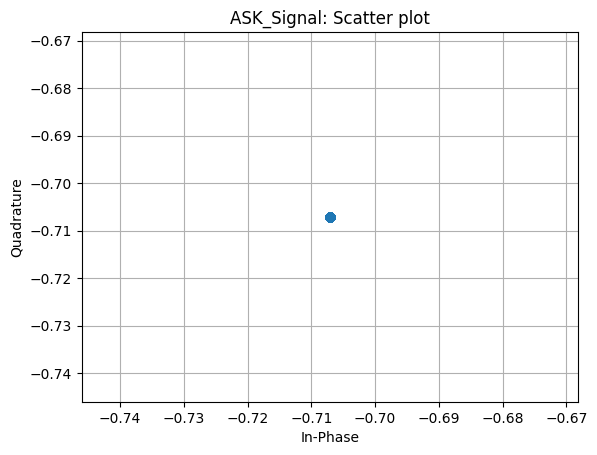

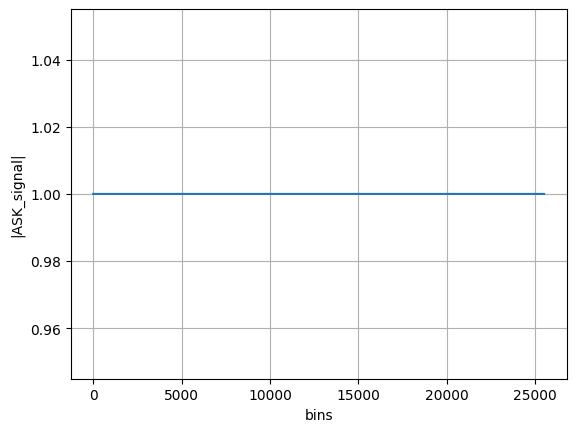

Frequency offset1: 0.0 Hz


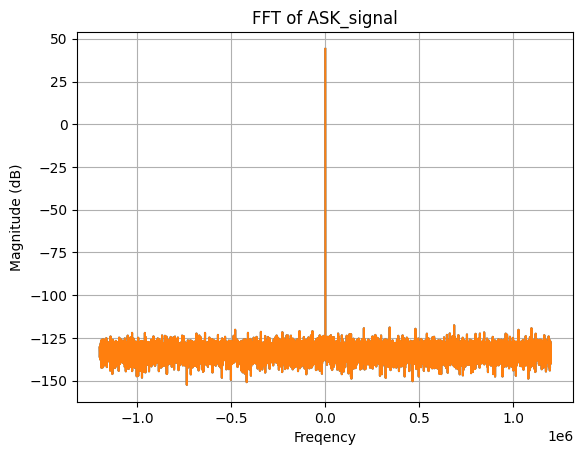

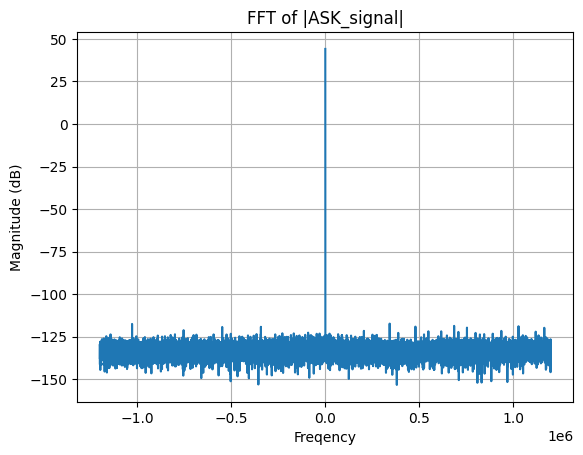

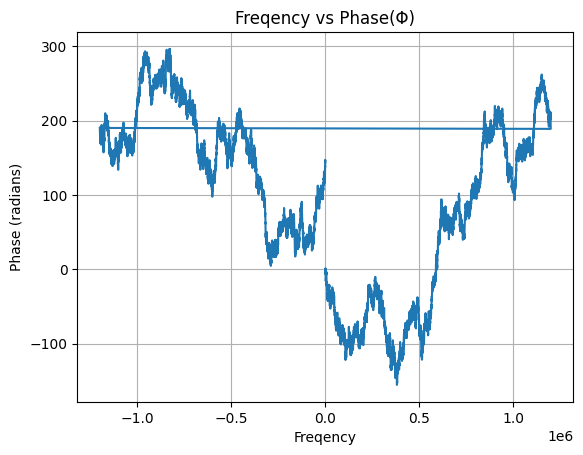

Clock Frequency: 94920.03762935089 Hz
Frequency bin: 1009
Φ: -87.90774937260076 radians


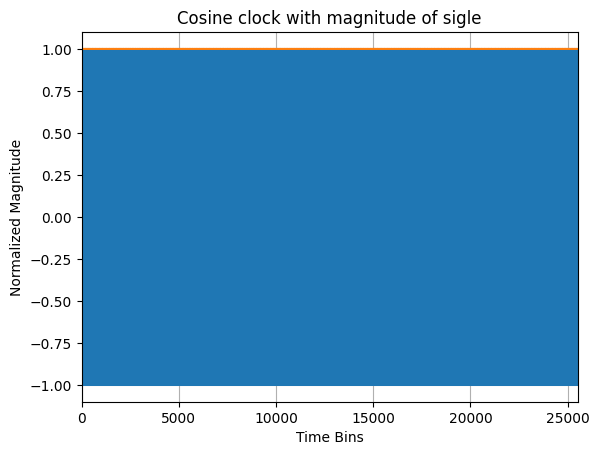

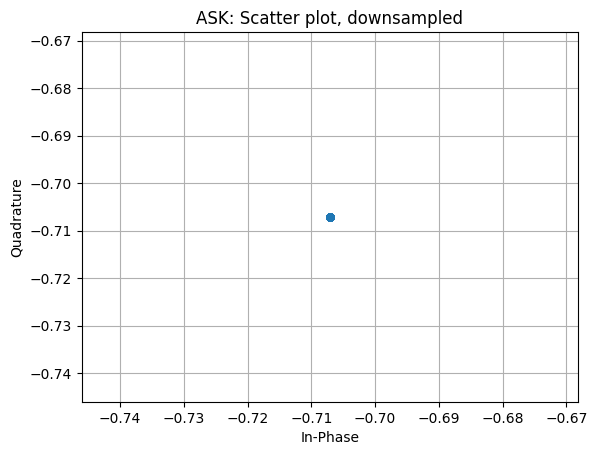

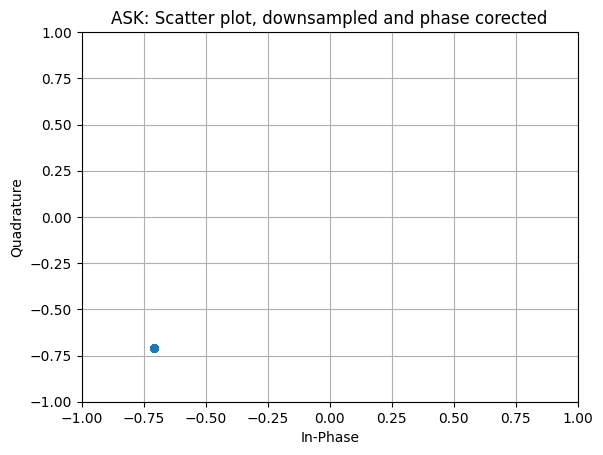

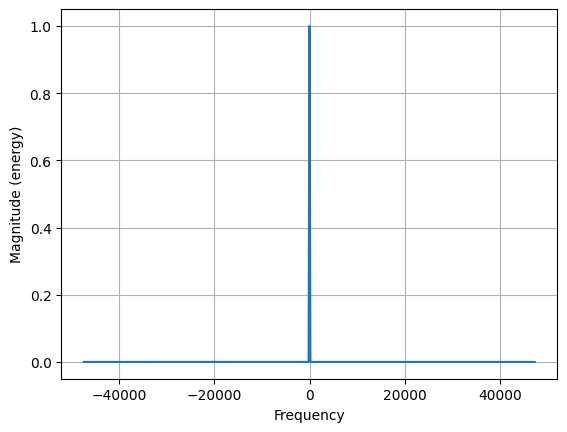

fine= 45782.05


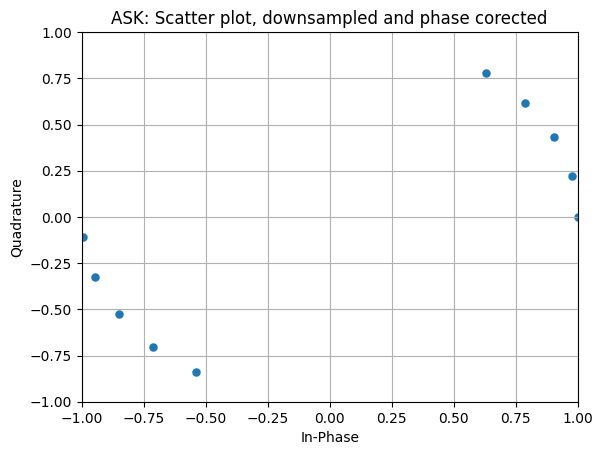

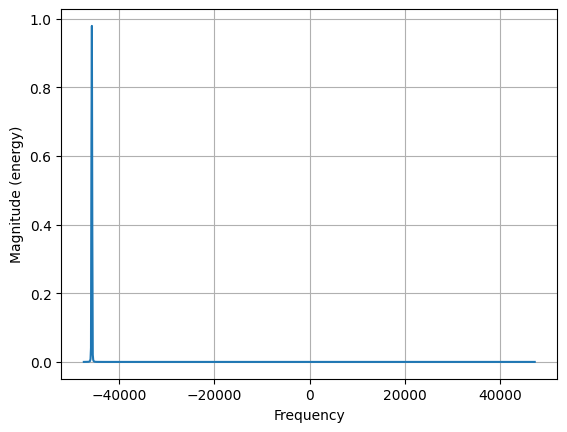

0010001000100010001101110111110111011000100010001000100010001000100010001001110111010111011101100010001000100010001000100010001000110111011111011101110010001000100010001000100010001000100011011101011101110110001000100010001000100010001000100010011101110101110111001000100010001000100010001000100010001101110111110111011100100010001000100010001000100010001000110111010111011101100010001000100010001000100010001000100111011101011101110010001000100010001000100010001000100011011101111101110111001000100010001000100010001000100010011101110101110111011000100010001000100010001000100010001001110111110111011100100010001000100010001000100010001000110111011111011101100010001000100010001000100010001000100111011101011101110110001000100010001000100010001000100010011101111101110111001000100010001000100010001000100010001101110111110111011000100010001000100010001000100010001001110111010111011101100010001000100010001000100010001000110111011111011101110010001000100010001000100010001000100011011101011101110110

In [4]:
ASK_I = I_samples[90764:116276]
ASK_Q = Q_samples[90764:116276]

#Making the data complex as demonstarted in esc_python_tut2.py
ASK_signal = ASK_I + 1j*ASK_Q
ASK_signal_abs = np.abs(ASK_signal)
#Normalizing the data
ASK_I = ASK_I / ASK_signal_abs.max()
ASK_Q = ASK_Q / ASK_signal_abs.max()

#Making the data complex as demonstarted in esc_python_tut2.py
ASK_signal = ASK_I + 1j*ASK_Q

#Scatter Plot of the ASK data.
plt.figure(1)
plt.scatter(np.real(ASK_signal), np.imag(ASK_signal)) 
plt.xlabel("In-Phase") 
plt.ylabel("Quadrature")
plt.title("ASK_Signal: Scatter plot")
plt.grid()
plt.show()

#create a freqency array
freq = np.fft.fftfreq(len(ASK_signal),1/fs)
#create a time array
dt = 1/(fs) #Timestep between samples 
bins=np.arange(0,len(ASK_signal),1)
t=bins*dt

#Carrier frequency synchronization.
#Need to correct the frequency offset between 0 of the carrier and the 0 of the data.

plt.figure(2)
plt.plot(bins,np.abs(ASK_signal))
plt.xlabel("bins") 
plt.ylabel("|ASK_signal|")
plt.grid()
plt.show()




ASK_SIGNAL = np.fft.fft(ASK_signal)
ASK_SIGNAL_dB = 10*np.log10(np.abs(ASK_SIGNAL))

#correction of the frequency offset
Δ_Φ = np.diff(np.unwrap((np.angle(ASK_signal[2:229]))))
freq_off = np.median(Δ_Φ)  / (np.pi*2*dt)  
print("Frequency offset1:",freq_off,'Hz')

ASK_signal_shift = ASK_signal*( np.cos(2*np.pi*(-1*freq_off)*t) + 1j*np.sin(2*np.pi*(-1*freq_off)*t) )




ASK_SIGNAL_SHIFT = np.fft.fft(ASK_signal_shift)
ASK_SIGNAL_SHIFT_dB = 10*np.log10(np.abs(ASK_SIGNAL_SHIFT))



plt.figure(3)
plt.plot(freq,ASK_SIGNAL_dB)
plt.plot(freq,ASK_SIGNAL_SHIFT_dB)
plt.xlabel("Freqency") 
plt.ylabel("Magnitude (dB)")
plt.title("FFT of ASK_signal")
plt.grid()
plt.show()


#Phase and Frequency of clock

ASK_SIGNAL_ABS = np.fft.fft(np.abs(ASK_signal))
ASK_SIGNAL_ABS_dB = 10*np.log10(np.abs(ASK_SIGNAL_ABS))

ASK_signal_phase = np.unwrap(np.angle(ASK_SIGNAL_ABS)) # "np.angle returns the equivalent of atan(imag/real)


plt.figure(4)
plt.plot(freq,ASK_SIGNAL_ABS_dB)
plt.xlabel("Freqency") 
plt.ylabel("Magnitude (dB)")
plt.title("FFT of |ASK_signal|")
plt.grid()
plt.show()

plt.figure(5)
plt.plot(freq,ASK_signal_phase)
plt.xlabel("Freqency")
plt.ylabel("Phase (radians)")
plt.title("Freqency vs Phase(Φ)")
plt.grid()
plt.show()

#Thus we obtain the frequency of the clock by looking for the largest spike above the noise.
f_clk = 94920.03762935089 #Hz
freq_δ = np.abs(freq[0]-freq[1])/2
#Now need to obtain the phase of the clock.
# I did this by using the index function which searches the array and returns the bin where that value is located
for i, j in enumerate(freq):
    if (f_clk-freq_δ) < j < (f_clk+freq_δ):
            freq_bin=(i)
#f_clk = freq[freq_bin]
Φ =ASK_signal_phase[freq_bin]

print('Clock Frequency:',f_clk,'Hz')
print('Frequency bin:',freq_bin)
print('Φ:',Φ,'radians')


#Once the phase is obtained we can use this in a cosine function to create a clock that we may sample the data from inorder to extract the indformation from the signal.
clock_signal = np.cos((2*np.pi*t*f_clk)+Φ)

plt.figure(6)
plt.plot(bins,clock_signal)
plt.plot(bins,np.abs(ASK_signal_shift))
plt.xlim(0,len(ASK_I))
plt.title("Cosine clock with magnitude of sigle")
plt.xlabel("Time Bins")
plt.ylabel("Normalized Magnitude")
plt.grid()
plt.show()


#Extracting the down sampled data
symbol_data = []
peak_bins = sp.find_peaks(clock_signal)
for i in peak_bins[0]:
    symbol_data.append(ASK_signal_shift[i])


    
#Normalizing the data
ASK_I_Symbol = np.real(symbol_data) / np.abs(symbol_data).max()
ASK_Q_Symbol = np.imag(symbol_data)/ np.abs(symbol_data).max()  
symbol_data = ASK_I_Symbol + 1j*ASK_Q_Symbol

plt.figure(7)
plt.scatter(np.real(symbol_data), np.imag(symbol_data),linewidths=0.1)
plt.xlabel("In-Phase") 
plt.ylabel("Quadrature")
plt.title("ASK: Scatter plot, downsampled")
plt.grid()
plt.show()

#Removing the phase offset this is done by multiplying by e^(j(phase of first symbol))

#Normalizing the data
ASK_I_Symbol = np.real(symbol_data) / np.abs(symbol_data).max()
ASK_Q_Symbol = np.imag(symbol_data)/ np.abs(symbol_data).max()  
symbol_data = ASK_I_Symbol + 1j*ASK_Q_Symbol

plt.figure(8)
plt.scatter(np.real(symbol_data), np.imag(symbol_data),linewidths=0.1) 
plt.xlabel("In-Phase")
plt.xlim(-1,1)
plt.ylabel("Quadrature")
plt.ylim(-1,1)
plt.title("ASK: Scatter plot, downsampled and phase corected")
plt.grid()
plt.show()

plt.figure(9)
mag,freqs,line = plt.magnitude_spectrum(symbol_data,Fs=f_clk)
plt.grid()
plt.show()

dt = 1/(f_clk) #Timestep between samples 
bins=np.arange(0,len(symbol_data),1)
t=bins*dt

freq_off =45782.05
print('fine=',freq_off)
symbol_data = symbol_data*np.e**(-1j*np.angle(symbol_data[0]))
symbol_data = symbol_data*( np.cos(2*np.pi*(-1*freq_off)*t) + 1j*np.sin(2*np.pi*(-1*freq_off)*t))


plt.figure(10)
plt.scatter(np.real(symbol_data[:10]), np.imag(symbol_data[:10]),linewidths=0.1) 
plt.xlabel("In-Phase")
plt.xlim(-1,1)
plt.ylabel("Quadrature")
plt.ylim(-1,1)
plt.title("ASK: Scatter plot, downsampled and phase corected")
plt.grid()
plt.show()

plt.figure(11)
plt.magnitude_spectrum(symbol_data,Fs=f_clk)
plt.grid()
plt.show()
real_symbol=np.real(symbol_data )
#real_symbol=real_symbol[0:len(real_symbol):1]
data=[]
for i, j in enumerate(real_symbol):
    if  -1 < j < - 0.5:
        data.append(0)
        data.append(0)
    if -0.5 < j < 0:
        data.append(0)
        data.append(1)
    if 0 < j < 0.5:
        data.append(1)
        data.append(1)
    if 0.5 < j < 1:
        data.append(1)
        data.append(0)
print(*data,sep='')